In [1]:
import os
import json
import numpy as np

from tqdm.notebook import tqdm
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output

from word2vec.trainer import Word2VecTrainer
from word_embeddings import WordEmbeddings
from utils import InternalDataCollector

import torch

import re
import codecs
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [2]:
import configparser 

config = configparser.ConfigParser()
config.read('config.ini')

female_words = config['GenderSpecificWords']['female_words'].split(', ')
male_words   = config['GenderSpecificWords']['male_words'].split(', ')

raw_text_dir          = config['Path']['raw_text_dir']
preprocessed_text_dir = config['Path']['preprocessed_text_dir']
input_path            = config['Path']['input_path']
output_dir            = config['Path']['output_dir']
images_dir            = config['Path']['images_dir']
embeddings_dir        = config['Path']['embeddings_dir']

lang = config['Language']['lang']

# Data preprocessing

In [3]:
def prepare_for_w2v(filename_from, filename_to, lang):
    stop_words = set(stopwords.words(lang))
    lemmatizer = WordNetLemmatizer()
    raw_text = codecs.open(filename_from, 'r', encoding='utf-8').read()
    
    with open(filename_to, 'w', encoding='utf-8') as f:
        for sentence in nltk.sent_tokenize(raw_text, lang):
            sentence = sentence.lower()
            sentence = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', sentence)
            sentence = re.sub(' +', ' ', sentence)
            sentence = sentence.strip()
            for word in nltk.word_tokenize(sentence):
                if word not in stop_words:
                    word = lemmatizer.lemmatize(word)
                    print(word, file=f, end=' ')
            print(file=f)
            
def process_raw_text():
    for path in os.listdir(raw_text_dir):
        filename_from = os.path.join(raw_text_dir, path)
        filename_to = os.path.join(preprocessed_text_dir, path)
        prepare_for_w2v(filename_from, filename_to, lang)
        
def create_input_file(input_path_, sources):
    merged_lines = []
    for source in sources:
        filename = os.path.join(preprocessed_text_dir, source + '.txt')
        lines = codecs.open(filename, 'r', encoding='utf-8').readlines()
        merged_lines += lines
    with open(input_path_, 'w') as f:
        f.writelines(merged_lines)

In [4]:
process_raw_text()

In [5]:
create_input_file(input_path, ['war_and_peace', 'anna_korenina'])

# Regularization

In [6]:
def create_positions(trainer, words):
    ids = [trainer.data.word2id[w] for w in words if w in trainer.data.word2id.keys()]
    return torch.LongTensor(ids).to(trainer.device)

def smart_reg(trainer, pos_u, pos_v, neg_v, males, females,
             alpha=0.1, beta=0.01, gamma=0.5):
    vec_males = trainer.skip_gram_model.u_embeddings(males)
    std_males = torch.std(vec_males[:, 0])
    mean_males = torch.mean(vec_males, 0)
    mean_0_males = torch.mean(vec_males[:, 0])
    
    vec_females = trainer.skip_gram_model.u_embeddings(females)
    std_females = torch.std(vec_females[:, 0])
    mean_females = torch.mean(vec_females, 0)
    mean_0_females = torch.mean(vec_females[:, 0])
    
    gender_std_loss = alpha*(std_males + std_females)/2
    gender_dist_loss = beta*-torch.log(10*torch.square(mean_0_males - mean_0_females))
    gender_bias_loss = 0
    if pos_u[0] not in males and pos_u[0] not in females:
        vec_u = trainer.skip_gram_model.u_embeddings(pos_u)
        gender_bias_loss = gamma*torch.square(torch.norm(vec_u - mean_females) - torch.norm(vec_u - mean_males))

    trainer.history['gender_std_loss'].append(gender_std_loss.cpu().detach())
    trainer.history['gender_dist_loss'].append(gender_dist_loss.cpu().detach())
    if gender_bias_loss != 0:
        trainer.history['gender_bias_loss'].append(gender_bias_loss.cpu().detach())
    else:
        trainer.history['gender_bias_loss'].append(0)
        
    return gender_std_loss + gender_dist_loss + gender_bias_loss

# Train embeddings

In [7]:
#Create word2vec trainer
output_path = os.path.join(output_dir, 'out.vec')
w2v = Word2VecTrainer(input_file=input_path, output_file=output_path,
                      emb_dimension=200, iterations=3, min_count=5, window_size=10,
                      initial_lr=0.0005, display=True)

Total embeddings: 7733


In [8]:
#Add internal data collector
idc = InternalDataCollector()
idc.add_data_key('man')
idc.add_data_key('woman')
idc.add_data_key('paper')
idc.add_data_key('horse')
end_of_step = lambda step: idc.step_filter(k=200, f=idc.splitter,
                                           args=([idc.add_word_surroundings_data, idc.add_word_surroundings_data,
                                                 idc.add_word_surroundings_data, idc.add_word_surroundings_data],
                                                 [('man', w2v, 'man', 50), ('woman', w2v, 'woman', 50),
                                                  ('paper', w2v, 'paper', 50), ('horse', w2v, 'horse', 50)]),
                                           step=step)
w2v.end_of_step = end_of_step

In [9]:
#Add regularization
males = create_positions(w2v, male_words)
females = create_positions(w2v, female_words)
reg = lambda trainer, pos_u, pos_v, neg_v: smart_reg(trainer, pos_u, pos_v, neg_v, males, females,
                                                    alpha=0.1, beta=0.01, gamma=0.5)
w2v.reg = reg
w2v.history['main'] = []
w2v.history['gender_std_loss'] = []
w2v.history['gender_dist_loss'] = []
w2v.history['gender_bias_loss'] = []

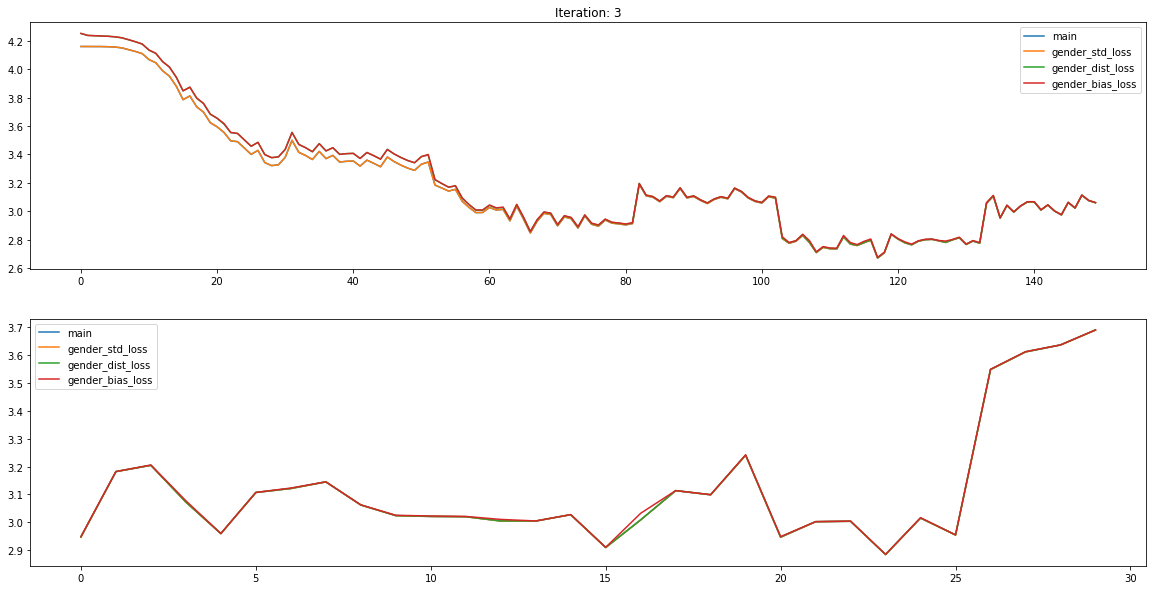

In [10]:
#Train
w2v.train()

In [11]:
#Update word2vec dictionary manualy if training process was interrupted
w2v._update_word2vec_dict()

In [12]:
#Save IDC data
name = 'test'
with open(os.path.join(output_dir, 'idc_data_{}.json'.format(name)), 'w') as f:
    idc.save_data(f)

In [13]:
#Save loss history to json
name = 'test'
history = {}
for key in w2v.history:
    history[key] = [tensor.cpu().detach().item() for tensor in w2v.history[key] if tensor != 0]
with open(os.path.join(output_dir, 'history_{}.json'.format(name)), 'w') as f:
    json.dump(history, f)

In [14]:
#Save embeddings
name = 'test'
embeddings = WordEmbeddings(w2v.data.word2id, w2v.word2vec)
embeddings.save(os.path.join(embeddings_dir, '{}.json'.format(name)))

# Vizualization and analysis

In [15]:
name = 'test'
embeddings = WordEmbeddings()
embeddings.load(os.path.join(embeddings_dir, '{}.json'.format(name)))

In [16]:
filtered_female_words = [x for x in female_words if x in embeddings.words]
filtered_male_words = [x for x in male_words if x in embeddings.words]

In [18]:
#Plot gender specific words
t = len(filtered_male_words)
words_of_interest = filtered_male_words + filtered_female_words

In [19]:
#Plot words with highest gender bias
t = 10
words_of_interest = sorted(embeddings.filtered_words, key=embeddings.m_diff)[:t]
words_of_interest += sorted(embeddings.filtered_words, key=embeddings.w_diff)[:t]

In [20]:
pca = PCA(n_components=2)
vec_of_interest = [embeddings.word2vec[x] for x in words_of_interest]
vec_of_interest_2d = pca.fit_transform(vec_of_interest)

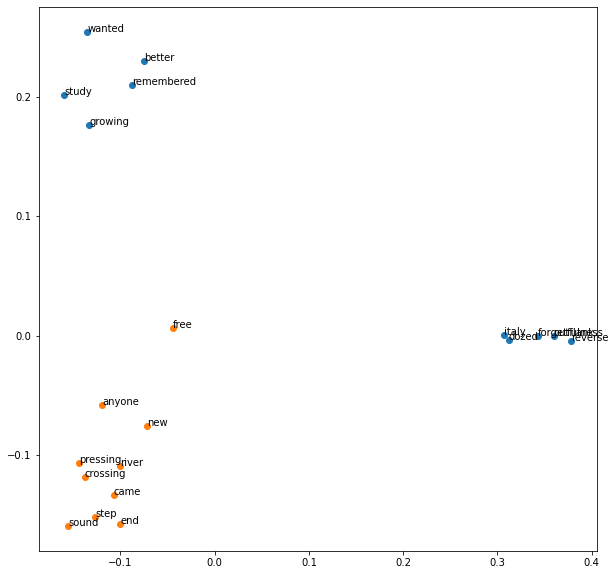

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(*vec_of_interest_2d[:t].T)
ax.scatter(*vec_of_interest_2d[t:].T)

for i, txt in enumerate(words_of_interest):
    ax.annotate(txt, vec_of_interest_2d[i])

In [22]:
#Compare distances between two genders
target = 'rosy'
embeddings.m_dist(target), embeddings.f_dist(target)

(0.6497479360867052, 0.6559635950664257)

In [23]:
#Word vector ariphmetics
v1 = np.array(embeddings.word2vec['king'])
v2 = np.array(embeddings.word2vec['man'])
v3 = np.array(embeddings.word2vec['woman'])
target_vector = v1 - v2 + v3
print(min(embeddings.words, key=lambda x: np.linalg.norm(target_vector - embeddings.word2vec[x])))

female


In [24]:
#Closest words
t = 10
target_vector = np.array(embeddings.word2vec['war'])
sorted(embeddings.words, key=lambda x: np.linalg.norm(target_vector - embeddings.word2vec[x]))[:t]

['war',
 'opinion',
 'advantage',
 'spite',
 'beginning',
 'single',
 'reading',
 'speech',
 'happening',
 'chance']